In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from hepunits import constants as c
from hepunits import units as u
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

u.dalton = 1.660539068e-27 * u.kg

In [1122]:
# Setup parameters
target_width = 1 * u.mm
beam_energy = 1 * u.GeV
beam_current = 100e-6 * u.A
beam_diameter = 100 * u.mm
beam_charge = -1

# Aluminium
#
# Not good, because of 26Al
# target_material = {'27Al': 1.0} # Mole-fractions
# target_density = 2.7 * u.g / u.cm3
# beam_time = 60 * u.s
# decay_time = 3 * 60 * u.s

# Phosphorus
#
# Could work, but... phosphorus :/
#target_material = {"31P": 1.0}  # Mole-fractions
#target_density = 2.7 * u.g / u.cm3  # Black phosphorus
#beam_time = 2 * u.h
#decay_time = 5 * u.h

# Phosphorus Pentoxide
#
# Problem: 14C, but ok, since much lower energy B-?
#target_material = {
#    "31P": 2 * 1.0,
#    "16O": 5 * 0.9976,
#    "17O": 5 * 0.0004,
#    "18O": 5 * 0.002,
#}  # Mole-fractions
#target_density = 2.4 * u.g / u.cm3
#beam_time = 3 * u.h
#decay_time = 6 * u.h

# Phosphoric acid
#
# Problem: neutrons and 14C.
#target_material = {
#    "1H": 3 * 0.99985,
#    "2H": 3 * 0.00015,
#    "31P": 1.0,
#    "16O": 4 * 0.9976,
#    "17O": 4 * 0.0004,
#    "18O": 4 * 0.002,
#}  # Mole-fractions
#target_density = 2.7 * u.g / u.cm3
#beam_time = 1 * u.h
#decay_time = 8 * u.h

# Lithium Phosphate
#
# Doesn't work, because of Li -> 3H
#target_material = {
#    "31P": 1.0,
#    "7Li": 3 * 0.95,
#    "6Li": 3 * 0.05,
#    "16O": 4 * 0.9976,
#    "17O": 4 * 0.0004,
#    "18O": 4 * 0.002,
#}  # Mole-fractions
#target_density = 2.7 * u.g / u.cm3
#beam_time = 2 * u.h
#decay_time = 4 * u.h

# Scandium
# Rad. length: 5.5 cm
#
# Could work, but 45Ca mean b- energy is only 77 keV
#target_material = {"45Sc": 1.0}  # Mole-fractions
#target_density = 3 * u.g / u.cm3
#beam_time = 100 * u.d
#decay_time = 60 * u.d

# Cobalt
# Rad. length: 1.5 cm
#
# Difficult because of all the Co isotopes
#target_material = {"59Co": 1.0}  # Mole-fractions
#target_density = 8.8 * u.g / u.cm3
#beam_time = 44 * u.d
#decay_time = 44 * u.d

# Silver
#
# Doesn't work because of 106Cd
# target_material = {"107Ag": 0.52, "109Ag": 0.48}  # Mole-fractions
# target_density = 10.5 * u.g / u.cm3
# beam_time = 100 * u.s
# decay_time = 14 * u.h

# Indium
#
# Not good, since Indium 115 itself is radioactive
# target_material = {"113In": 0.043, "115In": 0.957}  # Mole-fractions
# target_density = 7.3 * u.g / u.cm3
# beam_time = 0.1 * u.h
# decay_time = 100 * u.h

# Antimony
#
# Not good, because of 121Te
# target_material = {"123Sb": 0.428, "121Sb": 0.572}  # Mole-fractions
# target_density = 8.9 * u.g / u.cm3
# beam_time = 1 * u.d
# decay_time = 200 * u.d

# Praseodymium
#
# Noot good, because of 139Ce
# target_material = {'141Pr': 1.0} # Mole-fractions
# target_density = 6.8 * u.g / u.cm3
# beam_time = 1 * u.d
# decay_time = 45 * u.d
# beam_current = 0.01e-6 * u.A

# Tantalum
# Radiation length: 0.4 cm
#
# Lots of 179Ta, but E_gamma only 55 keV << 480 keV of 181Hf !
# 177 Lu only 15% gammas @ ~200 keV
# 178 W gamma < 60 keV
# 178 Ta -> 430 keV gammas :(
target_material = {'181Ta': 1.0} # Mole-fractions
target_density = 16.7 * u.g / u.cm3
beam_time = 17 * u.d
decay_time = 60 * u.d

beam_time_step = beam_time / 20
decay_time_step = decay_time / 400

In [1123]:
# Get decay rates and daughters of isotopes

import re
import urllib.request
from functools import lru_cache


@lru_cache(maxsize=None)
def lc_pd_dataframe(**kwargs):
    url = "https://nds.iaea.org/relnsd/v1/data?"
    url += "&".join((f"{k}={v}" for k, v in kwargs.items()))
    req = urllib.request.Request(url)
    req.add_header(
        "User-Agent",
        "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0",
    )
    return pd.read_csv(urllib.request.urlopen(req))

In [1124]:
all_ground_states = lc_pd_dataframe(fields="ground_states", nuclides="all")

@lru_cache(maxsize=None)
def AZN(nuclide):
    A, symbol = re.fullmatch("(\d+)(\S+)", nuclide).groups()
    A = int(A)
    ground_state = all_ground_states.query(f"n + z == {A} & symbol == '{symbol}'").iloc[
        0
    ]
    Z = ground_state["z"]
    N = ground_state["n"]
    return A, Z, N

In [1125]:
@lru_cache(maxsize=None)
def get_decay_rates(nuclide):
    A, symbol = re.fullmatch("(\d+)(\S+)", nuclide).groups()
    A = int(A)
    ground_state = all_ground_states.query(f"n + z == {A} & symbol == '{symbol}'").iloc[
        0
    ]
    half_life = ground_state[f"half_life_sec"] * u.s
    if np.isnan(half_life):
        half_life = 1e-99 * u.s
    Z = ground_state["z"]
    N = ground_state["n"]
    daughters = {}
    total_ratio = 0
    for i_d in range(1, 4):
        decay_mode = ground_state[f"decay_{i_d}"]
        if not isinstance(decay_mode, str):
            break
        decay_ratio = ground_state[f"decay_{i_d}_%"]
        if np.isnan(decay_ratio):
            decay_ratio = 1e-99

        if "B-" in decay_mode:
            d_n = N - 1
            d_z = Z + 1
        elif "B+" in decay_mode or "EC" in decay_mode:
            d_n = N + 1
            d_z = Z - 1
        elif "A" in decay_mode:
            d_n = N - 2
            d_z = Z - 2
        elif "N" in decay_mode:
            d_n = N - 1
            d_z = Z
        elif "P" in decay_mode:
            d_n = N
            d_z = Z - 1
        else:
            break

        try:
            d_symbol = all_ground_states.query(f"n == {d_n} & z == {d_z}").iloc[0][
                "symbol"
            ]
        except IndexError:
            continue

        decay = {"d_symbol": d_symbol, "d_n": d_n, "d_z": d_z}

        dsym = decay["d_symbol"]
        dA = decay["d_n"] + decay["d_z"]
        daughters[f"{dA}{dsym}"] = daughters.get(f"{dA}{dsym}", 0) + decay_ratio
        total_ratio += decay_ratio

    for k in daughters:
        # Normalise branching ratios
        daughters[k] /= total_ratio
        # Multiply with decay rate
        daughters[k] *= np.log(2) / half_life

    return daughters

In [1126]:
# Get activation cross sections for isotopes


def get_cross_sections(nuclide):
    A, Z, N = AZN(nuclide)
    
    # Very basic for now
    daughters = {}
    try:
        p_symbol = all_ground_states.query(f"n == {N} & z == {Z-1}").iloc[0]["symbol"]
        daughters[f"{A-1}{p_symbol}"] = Z * 4 * u.fm2  # Kick out a proton
    except IndexError:
        pass

    try:
        pn_symbol = all_ground_states.query(
            f"n == {N-beam_charge} & z == {Z+beam_charge}"
        ).iloc[0]["symbol"]
        daughters[f"{A}{pn_symbol}"] = (
            Z * 11e-42 * u.cm2
        )  # Turn a proton into a neutron or vice versa depending on beam charge
    except IndexError:
        pass

    try:
        n_symbol = all_ground_states.query(f"n == {N-1} & z == {Z}").iloc[0]["symbol"]
        daughters[f"{A-1}{n_symbol}"] = 100e-3 * u.barn  # Kick out a neutron
    except IndexError:
        pass

    return daughters

In [1127]:
# Initial number of nuclides
beam_area = c.pi * (beam_diameter / 2) ** 2
target_volume = beam_area * target_width
target_mass = target_volume * target_density
target_nucleons = target_mass / u.dalton

start_numbers = {}
A_total = 0
for nuc, rel in target_material.items():
    A, Z, N = AZN(nuc)
    A_total += A * rel

for nuc, rel in target_material.items():
    A, Z, N = AZN(nuc)
    start_numbers[nuc] = target_nucleons / A_total * rel

start_numbers

{'181Ta': 4.363939085499348e+23}

In [1128]:
get_cross_sections("31P")

{'30Si': 6e-23, '31Si': 1.6499999999999999e-38, '30P': 1e-23}

In [1129]:
# Simulate the irradiation
beamsteps = int(beam_time / beam_time_step)
decaysteps = int(decay_time / decay_time_step)
current_numbers = start_numbers
numbers = []


def add_numbers(time, current):
    for nuc, num in current.items():
        dec = get_decay_rates(nuc)
        rate = sum(dec.values())
        numbers.append(
            {"time": time, "nuclide": nuc, "number": num, "decay_rate": rate}
        )


add_numbers(0, current_numbers)


def simulate(current_numbers, start_time, time_step, num_steps, beam_on):
    time = start_time
    for _ in trange(num_steps):
        time += time_step
        next_numbers = dict(current_numbers)
        for nuc, current in current_numbers.items():
            for daughter, rate in get_decay_rates(nuc).items():
                decay_fraction = 1 - np.exp(-rate * time_step)
                decay_number = current * decay_fraction
                decay_number = min(decay_number, next_numbers[nuc])
                next_numbers[nuc] -= decay_number
                next_numbers[daughter] = next_numbers.get(daughter, 0) + decay_number

            if beam_on:
                for daughter, xsec in get_cross_sections(nuc).items():
                    rate = (
                        xsec
                        * (current / beam_area)
                        * (beam_current / c.eplus)
                        / current
                    )
                    interaction_fraction = rate * time_step
                    if interaction_fraction > 1e-6:
                        interaction_fraction = 1 - np.exp(-rate * time_step)
                    interaction_number = interaction_fraction * current
                    interaction_number = min(interaction_number, next_numbers[nuc])
                    next_numbers[nuc] -= interaction_number
                    next_numbers[daughter] = (
                        next_numbers.get(daughter, 0) + interaction_number
                    )

            # Prune
            prune = []
            for nuc, num in next_numbers.items():
                if num < 1e-9:
                    prune.append(nuc)
            for nuc in prune:
                del next_numbers[nuc]

        current_numbers = next_numbers
        add_numbers(time, current_numbers)

    return current_numbers, time

In [1130]:
beamed_numbers, beamed_time = simulate(
    start_numbers, 0, beam_time_step, beamsteps, True
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.90it/s]


In [1131]:
beamed_time / u.h

408.0

In [1132]:
beamed_numbers

{'181Ta': 4.363785255732484e+23,
 '180Hf': 1.5246427512859138e+19,
 '181Hf': 3595.769419974614,
 '180Ta': 2.546705107239524e+16,
 '179Lu': 25450889728464.83,
 '180Lu': 0.012474448616297373,
 '179Hf': 226965733038164.38,
 '180W': 1.108279026608709e+17,
 '179Ta': 1794363010014.915,
 '178Yb': 39956040.5056083,
 '178Lu': 380471552.21256185,
 '179Yb': 3.063562122436654e-08,
 '178Hf': 2227216715.0113826,
 '179W': 6127742430.473321,
 '178Ta': 104090.24743241396,
 '177Tm': 61.65151072607126,
 '177Yb': 624.499570671488,
 '177Lu': 14313.012271999609,
 '177Hf': 4493.538989681615,
 '178W': 2644.498493425147,
 '177Ta': 0.029939954026395273,
 '176Er': 9.34410104147432e-05,
 '176Tm': 0.001002333847190222,
 '176Yb': 0.08327290175369906,
 '176Lu': 0.02196726997729031,
 '177W': 0.0001385524341756023,
 '176Hf': 0.0006679290686090638,
 '175Tm': 1.0455671588953175e-07,
 '175Yb': 2.684488806756574e-07,
 '175Lu': 7.016413972545237e-08,
 '176Ta': 2.034534685611691e-09,
 '175Er': 1.4438035363664092e-09}

In [1133]:
decayed_numbers, decayed_time = simulate(
    beamed_numbers, beamed_time, decay_time_step, int(decaysteps), False
)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 14752.57it/s]


In [1134]:
decayed_time / u.d

77.0

In [1135]:
pairs = []
for nuc, num in beamed_numbers.items():
    decays = get_decay_rates(nuc)
    rate = sum(decays.values(), 0)
    activity = num * rate
    pairs.append((activity, nuc))
#    print(f"{nuc}: {num:e} -> {activity*u.h:e}")

In [1136]:
# Set palette
palette = {}
for i, (_, nuc) in enumerate(sorted(pairs, reverse=True)):
    palette[nuc] = f"C{i}"
# palette

In [1137]:
for nuc, num in decayed_numbers.items():
    decays = get_decay_rates(nuc)
    rate = sum(decays.values(), 0)
    print(f"{nuc}: {num:e} -> {num * rate*u.h:e}")

181Ta: 4.363785e+23 -> 0.000000e+00
180Hf: 1.526772e+19 -> 0.000000e+00
181Hf: 1.348048e+03 -> 9.184517e-01
179Hf: 2.525258e+14 -> 0.000000e+00
180W: 1.149994e+17 -> 5.051919e-06
179Ta: 1.691297e+12 -> 7.348214e+07
178Hf: 2.647751e+09 -> 0.000000e+00
178Ta: 2.858330e+00 -> 8.395098e-01
177Lu: 2.871691e+01 -> 1.248253e-01
177Hf: 1.946402e+04 -> 0.000000e+00
178W: 3.856105e+02 -> 5.155958e-01
176Yb: 8.436868e-02 -> 0.000000e+00
176Lu: 2.196727e-02 -> 4.619782e-17
176Hf: 6.679303e-04 -> 0.000000e+00
175Lu: 4.436130e-07 -> 0.000000e+00


In [1138]:
df = pd.DataFrame(numbers)
df["second"] = df["time"] / u.s
df["hour"] = df["time"] / u.h
df["day"] = df["time"] / u.d
df["stable"] = df["decay_rate"] == 0
df["activity"] = df["decay_rate"] * df["number"]
df["decays_per_second"] = df["activity"] * u.s
df["decays_per_hour"] = df["activity"] * u.h
df["decays_per_day"] = df["activity"] * u.d
df = df.query("decays_per_hour > 0.01")

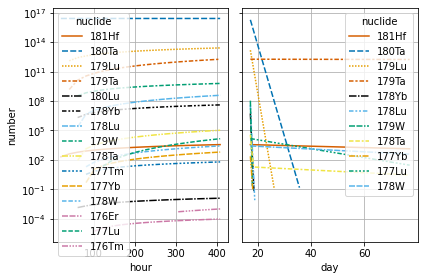

In [1139]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time}"),
    x="hour",
    y="number",
    hue="nuclide",
    style="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time}"),
    x="day",
    y="number",
    hue="nuclide",
    style="nuclide",
    ax=axs[1],
    palette=palette,
)
axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

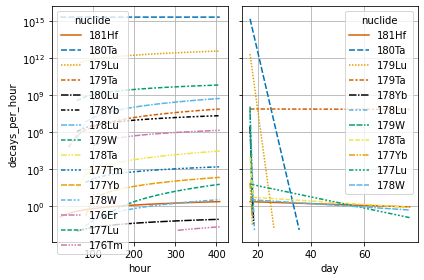

In [1140]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time}"),
    x="hour",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time}"),
    x="day",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[1],
    palette=palette,
)
axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

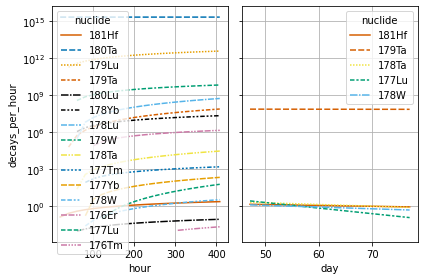

In [1141]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time}"),
    x="hour",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time + decay_time/2}"),
    x="day",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[1],
    palette=palette,
)

axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

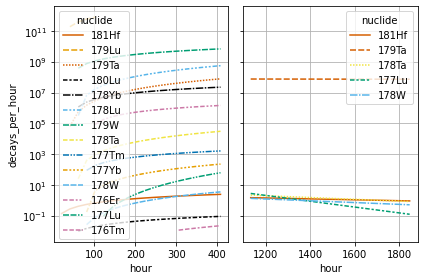

In [1142]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time} & decays_per_hour < 1e12"),
    x="hour",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time + decay_time/2} & decays_per_hour < 1e12"),
    x="hour",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[1],
    palette=palette,
)

axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

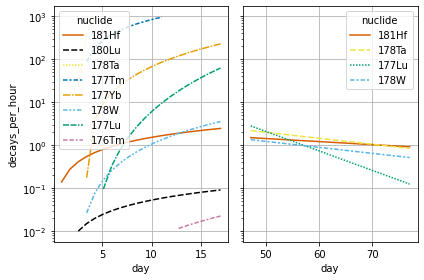

In [1143]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time} & decays_per_hour < 1e3"),
    x="day",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time + decay_time/2} & decays_per_hour < 1e3"),
    x="day",
    y="decays_per_hour",
    hue="nuclide",
    style="nuclide",
    ax=axs[1],
    palette=palette,
)

axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

In [1144]:
for d, r in get_decay_rates("16N").items():
    print(d, (r*u.s))

16O 0.09721559334641589
